In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# DoWhy imports 
import dowhy
from dowhy import CausalModel

# EconML imports
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                     SingleTreePolicyInterpreter

#sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

import pandas as pd
import numpy as np
import statsmodels.api as sm
import xgboost
from xgboost import XGBClassifier,XGBRegressor

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('***************/hotel_bookings.csv')

In [3]:
##shuffling dataset for randomness
data=data.sample(frac = 1)

In [4]:
len(data)

# Cleanup of File
 From my own experience working in the hospitality industry some of the most
 important metrics are the financial ones as well as the length of stay.  Most shop 
 within their price range and only reserve those rooms.

In [5]:
##total length of stay from weeknights and weekdays
data['length_of_stay']=data['stays_in_weekend_nights']+data['stays_in_week_nights']
data=data[ data.length_of_stay <=7 ]
data=data[data.length_of_stay>0]

data = data[data["deposit_type"].str.contains("No Deposit") == False]
dep_map = {'Refundable': 1, 'Non Refund': 0}
data["refund_or_non"] = data['deposit_type'].apply(lambda x: dep_map[x])

##one hot encode based off of the separate indicators
cat_cols=['hotel']
##rejoin original data
one_hot_data=pd.get_dummies(data[cat_cols])
##delete columns that were joined
data=data.drop(['hotel'],axis=1)
data=pd.concat([data,one_hot_data],axis=1)

# Define estimator inputs
Z = data['refund_or_non'] # nudge, or instrument
T = data['is_repeated_guest'] # intervention, or treatment
Y = data['length_of_stay'] # outcome of interest

##columns that aren't needed for analysis.  general take on this project is that previous activity and more
##generic information would have more impact on analysis.  
X_data = data.drop(columns=['is_repeated_guest','refund_or_non', 'is_canceled', 'length_of_stay','index', 
                            'arrival_date_year','arrival_date_day_of_month','arrival_date_month', 
                            'stays_in_weekend_nights','children','days_in_waiting_list',
                            'stays_in_week_nights', 'meal','country', 'distribution_channel','reserved_room_type',
                            'assigned_room_type', 'deposit_type', 'agent','company','arrival_date_week_number',
                            'customer_type','reservation_status', 'reservation_status_date','babies','lead_time',
                            'required_car_parking_spaces', 'booking_changes','total_of_special_requests','adults',
                            'adr','market_segment'],axis=1)

In [6]:
len(X_data)

In [7]:
feature_names = X_data.columns.tolist()

# Definine the models needed
XGBoost is chosen as the model according to the size of the datset as well as the accuracy.
Three are needed as there are an instrument variable, treatment variable and outcome variable.

In [8]:
# Define nuissance estimators
xgb_T_XZ_params = {
    'learning_rate': 0.1,
    'max_depth' : 5
}

xgb_Y_X_params = {
    'learning_rate': 0.1,
    'max_depth' : 5
}

##xgboost for classifier and regressor over lightgbm.  
model_T_XZ = XGBClassifier(**xgb_T_XZ_params)
model_Y_X = XGBRegressor(**xgb_Y_X_params)
flexible_model_effect = XGBRegressor(**xgb_Y_X_params)

# Initiating the Conditional Average Treatment Estimator
Model is initialized to estimate the parameters

In [9]:
# initiate an EconML cate estimator
est = LinearIntentToTreatDRIV(model_t_xwz=model_T_XZ, model_y_xw=model_Y_X,
                            flexible_model_effect=flexible_model_effect,
                            featurizer=PolynomialFeatures(degree=1, include_bias=False))

# Fitting Model
Model is fit to the instrument variable, treatment and outcome.  The test set is 1% of the data.

In [10]:
# fit through dowhy
test_customers = X_data.iloc[:150]
est_dw=est.dowhy.fit(Y, T, Z=Z, X=X_data, outcome_names=["length_of_stay"], treatment_names=["is_repeated_guest"],
                     feature_names=feature_names, instrument_names=["refund_or_non"], target_units=test_customers,
                     inference="statsmodels")

<Figure size 1000x800 with 0 Axes>

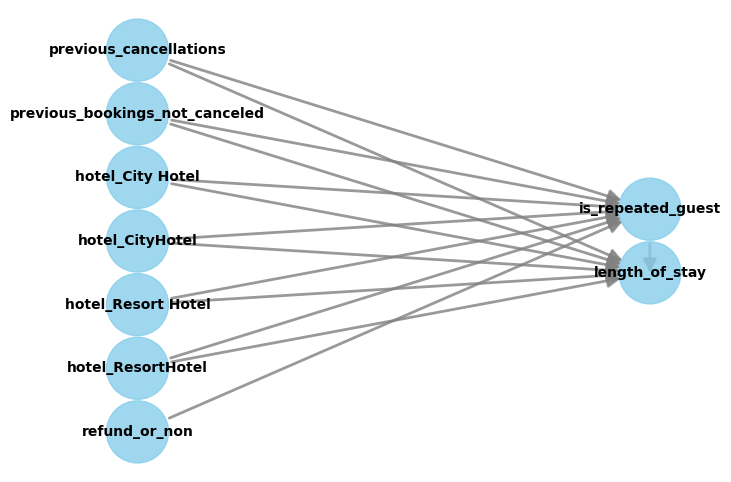

In [11]:
# Visualize causal graph
plt.figure(figsize=(10,8))
est_dw.view_model(layout=None) 

In [12]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
────────────────────(E[length_of_stay|previous_bookings_not_canceled,hotel_Res
d[is_repeated_guest]                                                          

                                                                              
ort Hotel,hotel_CityHotel,hotel_City Hotel,hotel_ResortHotel,previous_cancella
                                                                              

       
tions])
       
Estimand assumption 1, Unconfoundedness: If U→{is_repeated_guest} and U→length_of_stay then P(length_of_stay|is_repeated_guest,previous_bookings_not_canceled,hotel_Resort Hotel,hotel_CityHotel,hotel_City Hotel,hotel_ResortHotel,previous_cancellations,U) = P(length_of_stay|is_repeated_guest,previous_bookings_not_canceled,hotel_Resort Hotel,hotel_CityHotel,hotel_City Hotel,hotel_ResortHotel

# Model estimate on test set
4.57 is the mean value from the model.  This is what we will want to be close to later on.

In [13]:
lineardml_estimate = est_dw.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
────────────────────(E[length_of_stay|previous_bookings_not_canceled,hotel_Res
d[is_repeated_guest]                                                          

                                                                              
ort Hotel,hotel_CityHotel,hotel_City Hotel,hotel_ResortHotel,previous_cancella
                                                                              

       
tions])
       
Estimand assumption 1, Unconfoundedness: If U→{is_repeated_guest} and U→length_of_stay then P(length_of_stay|is_repeated_guest,previous_bookings_not_canceled,hotel_Resort Hotel,hotel_CityHotel,hotel_City Hotel,hotel_ResortHotel,previous_cancellations,U) = P(length_of_stay|is_repeated_guest,previous_bookings_not_canceled,hotel_Resort Hotel,ho

In [14]:
##assists with the treatment effect
est_dw.summary(feature_names=X_data.columns)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
previous_cancellations,-1.115,1.545,-0.722,0.47,-4.142,1.912
previous_bookings_not_canceled,175.806,40.487,4.342,0.0,96.454,255.159
hotel_City Hotel,-40.256,10.475,-3.843,0.0,-60.787,-19.725
hotel_CityHotel,-50.673,11.572,-4.379,0.0,-73.354,-27.993
hotel_Resort Hotel,-43.422,14.243,-3.049,0.002,-71.338,-15.505
hotel_ResortHotel,-0.256,0.564,-0.453,0.65,-1.361,0.85
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,41.455,10.525,3.939,0.0,20.826,62.083


# Adding a random common cause 
Close to 4.57 within reason 

In [15]:
res_random = est_dw.refute_estimate(method_name="random_common_cause", num_simulations=10)
print(res_random)

Refute: Add a random common cause
Estimated effect:4.570801741639592
New effect:5.217992885903525
p value:0.04106484693787314



# Adding an unobserved common cause to check accuracy
Normal for number to be a little larger

In [16]:
res_unobserved = est_dw.refute_estimate(method_name="add_unobserved_common_cause",
                                       confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                       effect_strength_on_treatment=0.05, effect_strength_on_outcome=0.5)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:4.570801741639592
New effect:6.062729955534654



# Placebo treatment refuter
Ideally should be closer to zero.  Increasing the number of simulations would help with that.  4.09 was
brought down from 10.

In [17]:
res_placebo = est_dw.refute_estimate(method_name="placebo_treatment_refuter", placebo_type="permute", 
                                     num_simulations=20)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:4.570801741639592
New effect:4.096238366131127
p value:0.0038885590296019457



# Using a subset of data to test
Extremely close match so is indicative of a good fitting of the model

In [18]:
# Removing a random subset of the data
res_subset = est_dw.refute_estimate(method_name="data_subset_refuter", subset_fraction=0.8, 
                                    num_simulations=20)
print(res_subset)

Refute: Use a subset of data
Estimated effect:4.570801741639592
New effect:4.571406479526077
p value:0.4996017217662192



# Interpretation of the model uncertainty
Hotels that aren't CityHotels are the target group that is most effected

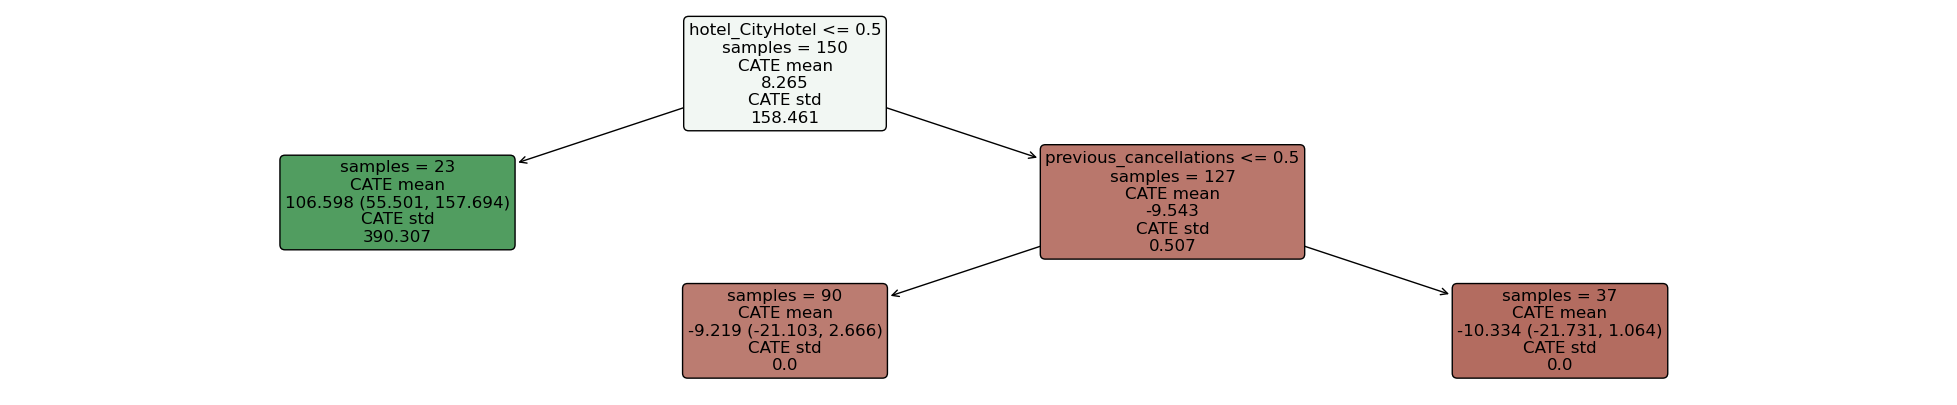

In [19]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est_dw, test_customers)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_data.columns, fontsize=12)

# Policy Interpreter
Shows which positive or negative treatment has the best effect.  In our case the average treatment will increase
days stayed by 18.  Positive treatment is becoming a repeated guest and the instrument was giving some a refundable deposit
vs. remaining non-refundable

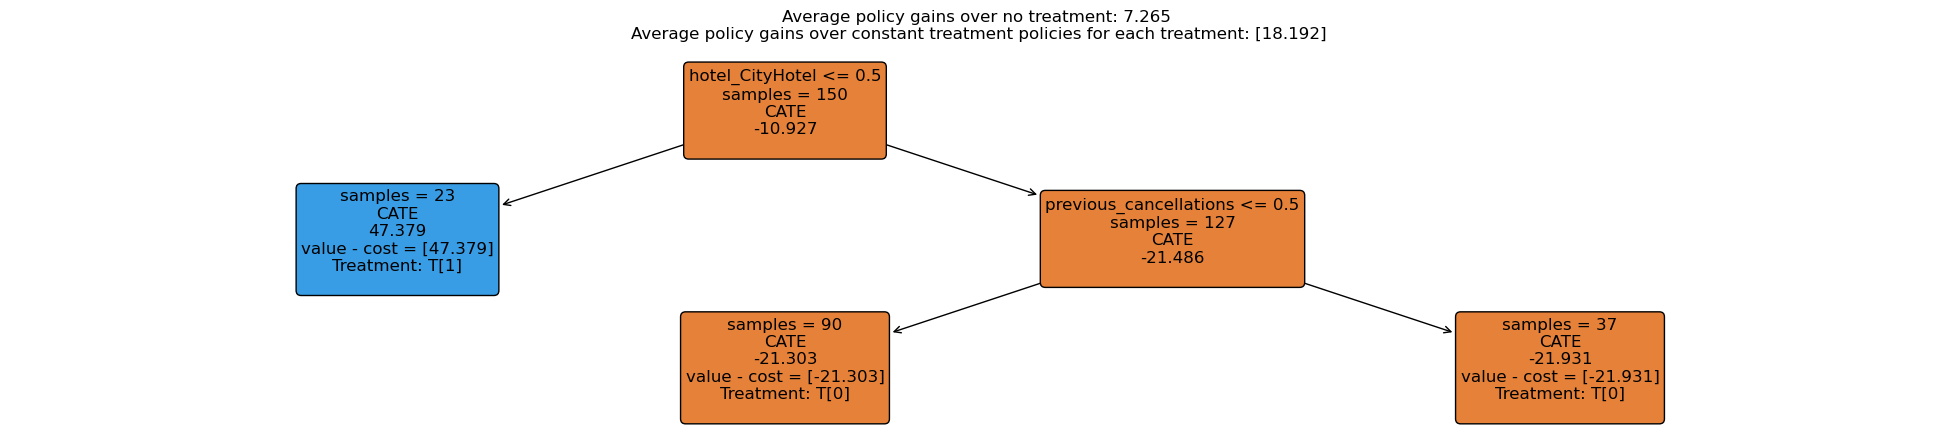

In [20]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=10)
intrp.interpret(est_dw, test_customers, sample_treatment_costs=0.2)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_data.columns, fontsize=12)